In [62]:
import tensorflow as tf
import os

In [63]:
# Avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Remove Unnecessary Images

In [64]:
import cv2
import imghdr

In [65]:
data_dir = 'data'

In [66]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [67]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Load Data into Keras

In [68]:
import numpy as np
from matplotlib import pyplot as plt

In [69]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 239 files belonging to 2 classes.


In [70]:
data_iterator = data.as_numpy_iterator()

In [71]:
batch = data_iterator.next()

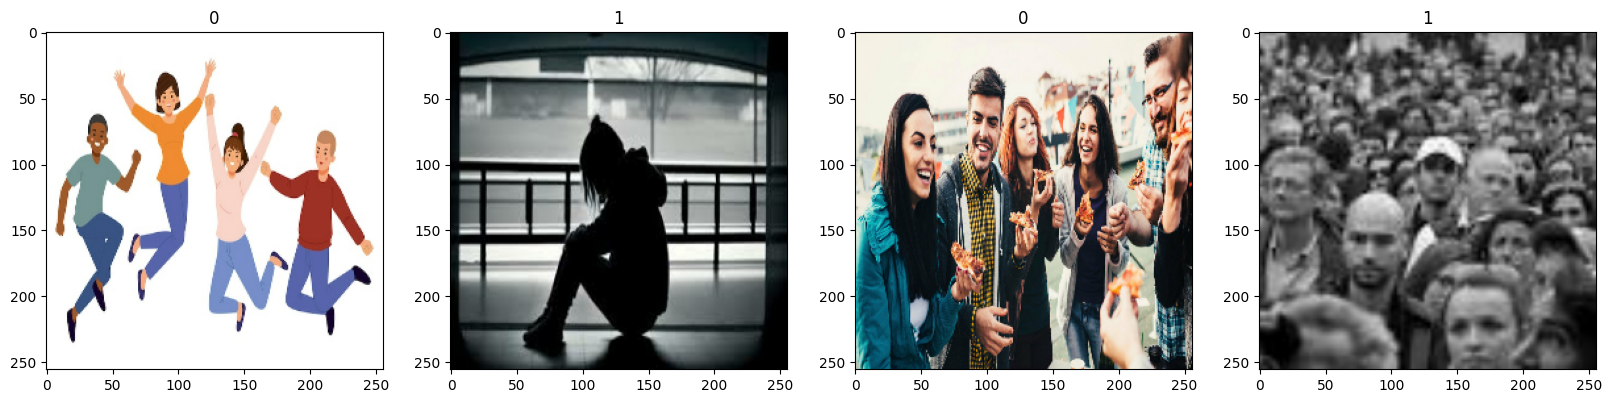

In [72]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [73]:
data = data.map(lambda x,y: (x/255, y))

In [74]:
scaled_iterator = data.as_numpy_iterator()

In [75]:
batch = scaled_iterator.next()

Data Split

In [76]:
train_size = int(len(data) * .6)
val_size = int(len(data) * .2) * 1
test_size = int(len(data) * .2) * 1

In [77]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

 Deep Modeling

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Conv2D: Convolutional Layer that has Filters/Kernels that capture different features from the input data, could be edge, textures or other visual patterns

MaxPooling2D: Max Pooling Layer that reduces the size of the input data by taking the maximum value from the input data.

Flatten: Flattens the input data into a 1-D vector.

Dense: Fully Connected Layer that performs a linear transformation on the input data.

Dropout: Dropout Layer that randomly sets input units to 0 with a given probability

In [79]:
model = Sequential()

In [80]:
model.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [83]:
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

Model Training

In [85]:
logdir = 'logs'

In [86]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [89]:
hist.history

{'loss': [1.033788800239563,
  0.704937219619751,
  0.6408883333206177,
  0.6052708625793457,
  0.5121830701828003,
  0.4750567078590393,
  0.32458293437957764,
  0.37222495675086975,
  0.3451133668422699,
  0.22111904621124268,
  0.2252267450094223,
  0.1722746044397354,
  0.13593624532222748,
  0.09516134858131409,
  0.1307845413684845,
  0.0789148360490799,
  0.08342523127794266,
  0.07979178428649902,
  0.052193187177181244,
  0.06708793342113495],
 'accuracy': [0.53125,
  0.6328125,
  0.8046875,
  0.71875,
  0.734375,
  0.78125,
  0.8671875,
  0.8359375,
  0.921875,
  0.953125,
  0.8984375,
  0.9453125,
  0.953125,
  0.953125,
  0.953125,
  0.9765625,
  0.984375,
  0.9921875,
  1.0,
  0.96875],
 'val_loss': [0.8082650899887085,
  0.6590234637260437,
  0.5319520235061646,
  0.4811735153198242,
  0.5028075575828552,
  0.35054802894592285,
  0.267631471157074,
  0.35587096214294434,
  0.33857262134552,
  0.28710055351257324,
  0.15259280800819397,
  0.13300448656082153,
  0.124561369

Plotting the Performance of the Model

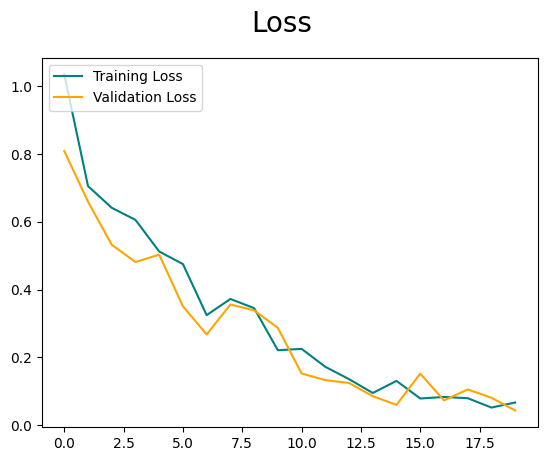

In [92]:
fig =  plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Training Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


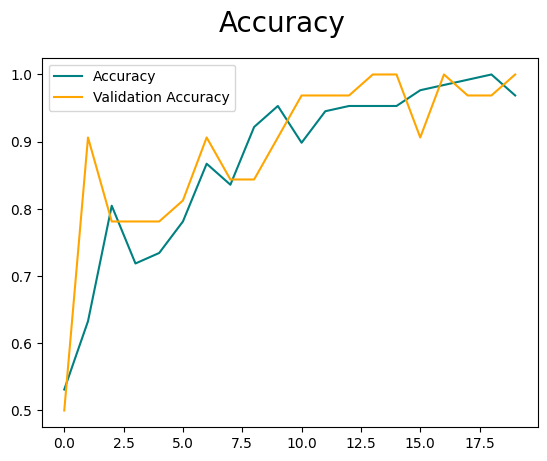

In [93]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate the Model's Performance

In [94]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [95]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [96]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 189ms/step


In [97]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


Testing the Model

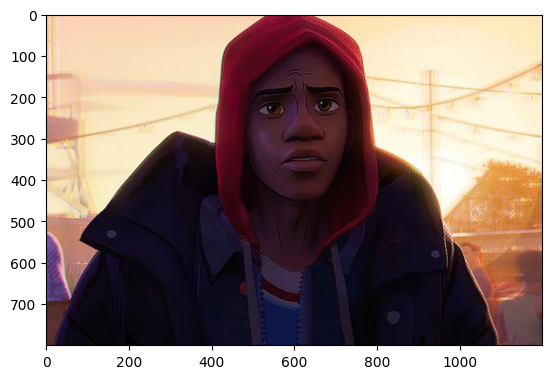

In [109]:
img = cv2.imread('sadtest.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

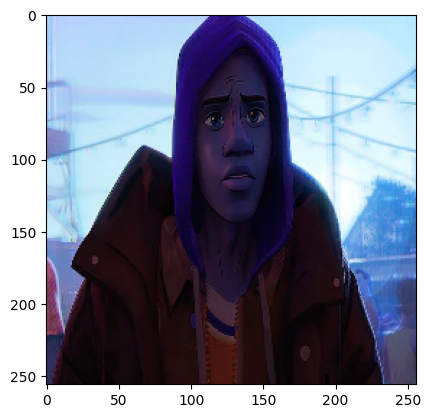

In [110]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [111]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 30ms/step


In [112]:
yhat

array([[0.9625829]], dtype=float32)

In [114]:
if yhat > 0.5:
    print("They're sad!")
else:
    print("They're happy :)")

They're sad!


In [117]:
from tensorflow.keras.models import load_model

In [116]:
model.save(os.path.join('models', "happysadmodel.h5"))

c:\Users\tbtw0\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Loading the Model for Testing Purposes

In [118]:
new_model = load_model(os.path.join('models', "happysadmodel.h5"))


In [119]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 80ms/step


array([[0.9625829]], dtype=float32)